## Exploring the data

In [1]:
import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['5004_2003.jpg', '44960_2014.jpg', '56775_2017.jpg', '25388_2009.jpg', '62272_2019.jpg', '36481_2012.jpg', '35380_2011.jpg', '43140_2013.jpg', '41862_2013.jpg', '61479_2018.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#image = ((image * std) + mean) --> transform image back in [0 1] range
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

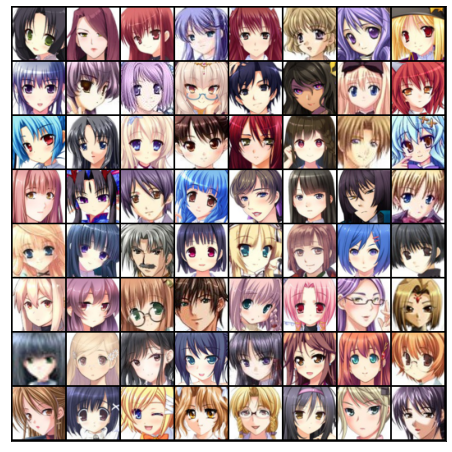

In [9]:
show_batch(train_dl)

## Using a GPU

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator network

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    # in: 64 x 32 x 32
    #add appropriate NN layers (conv2d, batch norm and leaky relu)
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    # in: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # in: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    #Add only conv2d layer here to output 1x1x1 value
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # changed stride to 1 from 2
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

## Generator network

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


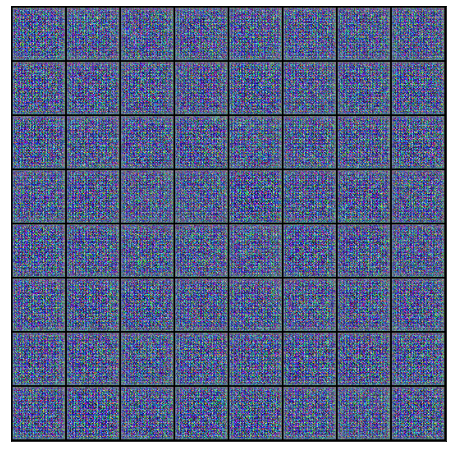

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

## Discriminator training

In [20]:
import torch.nn.functional as F

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # print("IN train_discriminator", fake_images.shape)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images) # maybe need to use .detach()
    fake_targets = torch.zeros(fake_preds.shape[0], 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    

    # Update discriminator weights
    loss = real_loss + fake_loss
    opt_d.zero_grad()
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator training

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


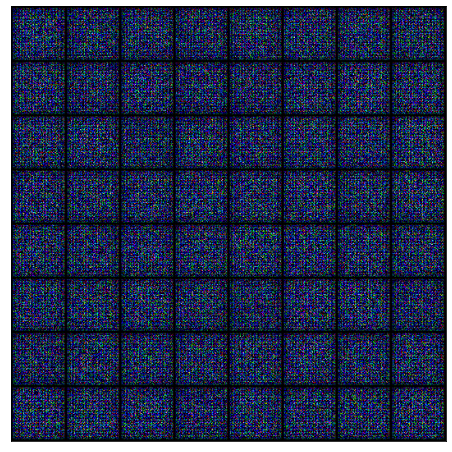

In [26]:
save_samples(0, fixed_latent)

In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()
  
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  
  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  loss_d = 0
  loss_g = 0
  real_score = 0
  fake_score = 0
  
  for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(train_dl)):
      real_images = real_images.to(device)
      
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

      # Train generator
      loss_g = train_generator(opt_g)
        
        
    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)
    
  return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 25

In [30]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.5902, loss_d: 0.5580, real_score: 0.8397, fake_score: 0.2607
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.0964, loss_d: 0.3999, real_score: 0.9220, fake_score: 0.2528
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 5.6603, loss_d: 0.4962, real_score: 0.9118, fake_score: 0.2990
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.6434, loss_d: 0.4429, real_score: 0.7130, fake_score: 0.0090
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.5508, loss_d: 0.2395, real_score: 0.8597, fake_score: 0.0632
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 7.1963, loss_d: 0.0614, real_score: 0.9451, fake_score: 0.0016
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.8362, loss_d: 0.3137, real_score: 0.8016, fake_score: 0.0212
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.1530, loss_d: 0.2297, real_score: 0.8211, fake_score: 0.0092
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.5804, loss_d: 0.2222, real_score: 0.8770, fake_score: 0.0642
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.0342, loss_d: 0.2256, real_score: 0.8547, fake_score: 0.0191
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.4190, loss_d: 0.2523, real_score: 0.8177, fake_score: 0.0143
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 4.6800, loss_d: 0.2411, real_score: 0.9256, fake_score: 0.1284
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.2300, loss_d: 0.0855, real_score: 0.9867, fake_score: 0.0660
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 1.0338, loss_d: 3.4637, real_score: 0.0656, fake_score: 0.0000
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.2273, loss_d: 0.0966, real_score: 0.9386, fake_score: 0.0255
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.5695, loss_d: 0.1601, real_score: 0.8922, fake_score: 0.0288
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.2858, loss_d: 0.1873, real_score: 0.8616, fake_score: 0.0096
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 8.4992, loss_d: 0.2733, real_score: 0.9868, fake_score: 0.2080
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.6774, loss_d: 0.0951, real_score: 0.9734, fake_score: 0.0617
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.2159, loss_d: 0.2320, real_score: 0.8374, fake_score: 0.0091
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.3660, loss_d: 0.0197, real_score: 0.9890, fake_score: 0.0083
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.7954, loss_d: 0.1339, real_score: 0.9857, fake_score: 0.1029
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.4439, loss_d: 0.0901, real_score: 0.9786, fake_score: 0.0623
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.4065, loss_d: 0.0422, real_score: 0.9952, fake_score: 0.0357
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.8272, loss_d: 0.0912, real_score: 0.9227, fake_score: 0.0053
Saving generated-images-0025.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [33]:
from IPython.display import Image

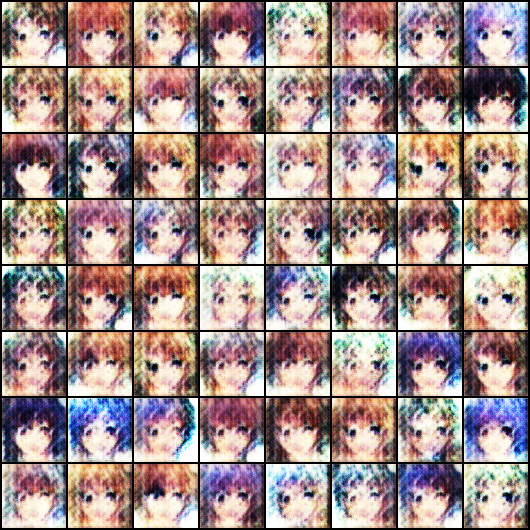

In [34]:
Image('./generated/generated-images-0001.png')

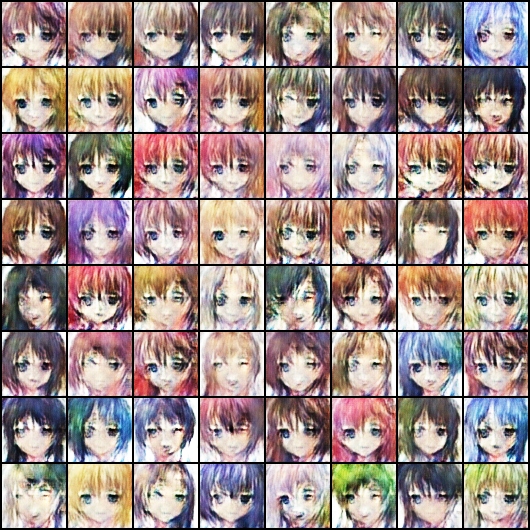

In [35]:
Image('./generated/generated-images-0005.png')

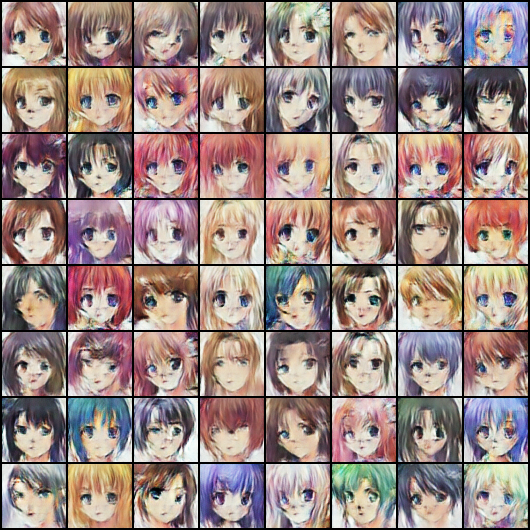

In [36]:
Image('./generated/generated-images-0010.png')

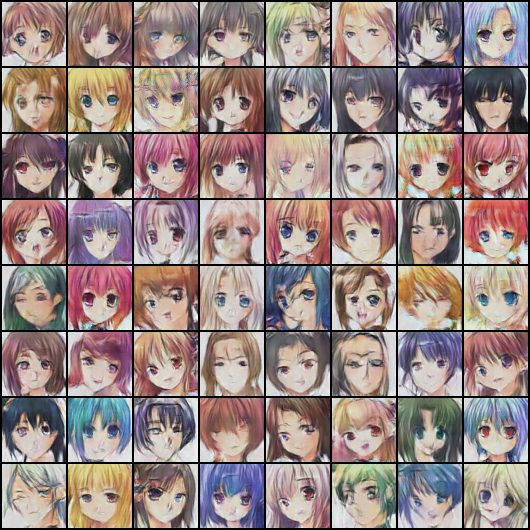

In [37]:
Image('./generated/generated-images-0020.png')

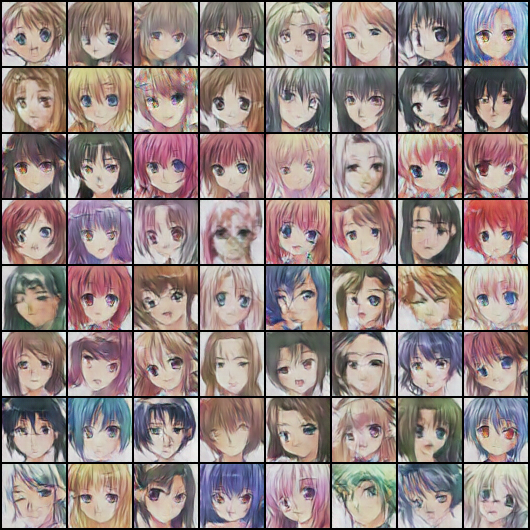

In [38]:
Image('./generated/generated-images-0025.png')

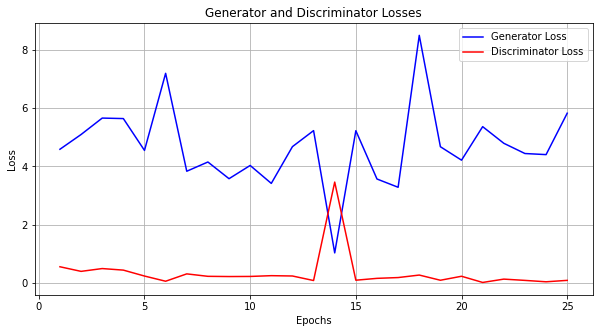

In [40]:
#Plot Loss of Generator and Discriminator
def plot_losses(losses_g, losses_d):
    epochs = range(1, len(losses_g) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses_g, label='Generator Loss', color='blue')
    plt.plot(epochs, losses_d, label='Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(losses_g, losses_d)

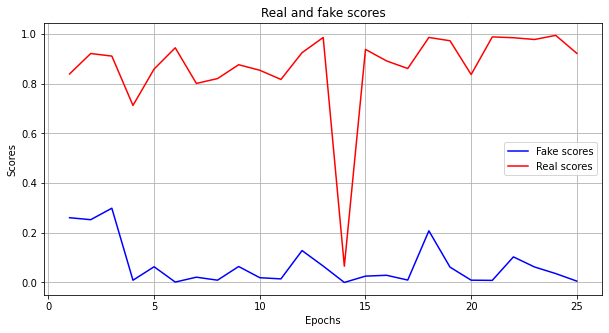

In [41]:
#Plot Real and Fake scores
def plot_scores(real_scores, fake_scores):
    epochs = range(1, len(real_scores) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, fake_scores, label='Fake scores', color='blue')
    plt.plot(epochs, real_scores, label='Real scores', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Real and fake scores')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_scores(real_scores, fake_scores)